# Pet Dataset Preprocessing and Augmentation

This notebook demonstrates the preprocessing and augmentation of a pet segmentation dataset. We'll:
1. Import the necessary libraries and load the modified data preprocessing script
2. Explore the original dataset structure
3. Visualize the transformations on sample images
4. Create an augmented dataset
5. Create data loaders with 80-20 train-val split
6. Verify the results

## 1. Import Libraries and Data Preprocessing Module

In [12]:
import os
import sys
import shutil
import torch
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import random
from scipy.ndimage import gaussian_filter, map_coordinates
import matplotlib.pyplot as plt


# Get the absolute path to the project root directory (parent of both notebooks and src)
project_root = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
sys.path.append(project_root)

# Then import the module directly
from src.data_preprocessing import JointTransform, PetDataset, create_augmented_dataset, get_data_loaders

## 2. Explore Original Dataset Structure

In [13]:
# Define dataset paths
data_root = '../Dataset/'
augmented_data_root = '../Dataset_augmented/'

# Check original dataset structure
train_val_color_dir = os.path.join(data_root, 'TrainVal', 'color')
train_val_label_dir = os.path.join(data_root, 'TrainVal', 'label')
test_color_dir = os.path.join(data_root, 'Test', 'color')
test_label_dir = os.path.join(data_root, 'Test', 'label')

print("Original dataset structure:")
print(f"TrainVal color: {os.path.exists(train_val_color_dir)}, Files: {len(os.listdir(train_val_color_dir) if os.path.exists(train_val_color_dir) else 0)}")
print(f"TrainVal label: {os.path.exists(train_val_label_dir)}, Files: {len(os.listdir(train_val_label_dir) if os.path.exists(train_val_label_dir) else 0)}")
print(f"Test color: {os.path.exists(test_color_dir)}, Files: {len(os.listdir(test_color_dir) if os.path.exists(test_color_dir) else 0)}")
print(f"Test label: {os.path.exists(test_label_dir)}, Files: {len(os.listdir(test_label_dir) if os.path.exists(test_label_dir) else 0)}")

Original dataset structure:
TrainVal color: True, Files: 3680
TrainVal label: True, Files: 3680
Test color: True, Files: 3710
Test label: True, Files: 3710


## 3. Define Helper Functions for Visualization

In [14]:
def visualize_sample(image, mask, title="Sample"):
    """Visualize an image and its segmentation mask"""
    if isinstance(image, torch.Tensor):
        image_np = image.permute(1, 2, 0).numpy()
    else:
        image_np = np.array(image)
    
    if isinstance(mask, torch.Tensor):
        mask_np = mask.numpy()
    else:
        mask_np = np.array(mask)
    
    # Create a colormap for the mask
    mask_colors = np.array([
        [0, 0, 0],          # Background (black)
        [1, 0, 0],          # Cat (red)
        [0, 1, 0],          # Dog (green)
        [1, 1, 1],          # Ignore (white)
    ])
    
    # Create colored mask
    colored_mask = np.zeros((mask_np.shape[0], mask_np.shape[1], 3))
    for i in range(3):  # Background, Cat, Dog
        colored_mask[mask_np == i] = mask_colors[i]
    # Handle ignore index
    colored_mask[mask_np == 255] = mask_colors[3]
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image_np)
    axes[0].set_title(f"{title} - Image")
    axes[0].axis('off')
    
    axes[1].imshow(colored_mask)
    axes[1].set_title(f"{title} - Mask")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
def process_mask_for_visualization(mask_pil):
    """Process a mask PIL image to create a segmentation mask for visualization"""
    mask_np = np.array(mask_pil)
    seg_mask = np.zeros(mask_np.shape[:2], dtype=np.uint8)
    
    # Background (black)
    black_mask = (mask_np[:,:,0] == 0) & (mask_np[:,:,1] == 0) & (mask_np[:,:,2] == 0)
    seg_mask[black_mask] = 0
    # Cat (red)
    red_mask = (mask_np[:,:,0] == 128) & (mask_np[:,:,1] == 0) & (mask_np[:,:,2] == 0)
    seg_mask[red_mask] = 1
    # Dog (green)
    green_mask = (mask_np[:,:,0] == 0) & (mask_np[:,:,1] == 128) & (mask_np[:,:,2] == 0)
    seg_mask[green_mask] = 2
    # White border (ignore)
    white_mask = (mask_np[:,:,0] == 255) & (mask_np[:,:,1] == 255) & (mask_np[:,:,2] == 255)
    seg_mask[white_mask] = 255  # Use 255 as ignore index
    
    return seg_mask

## 4. Visualize Original Sample

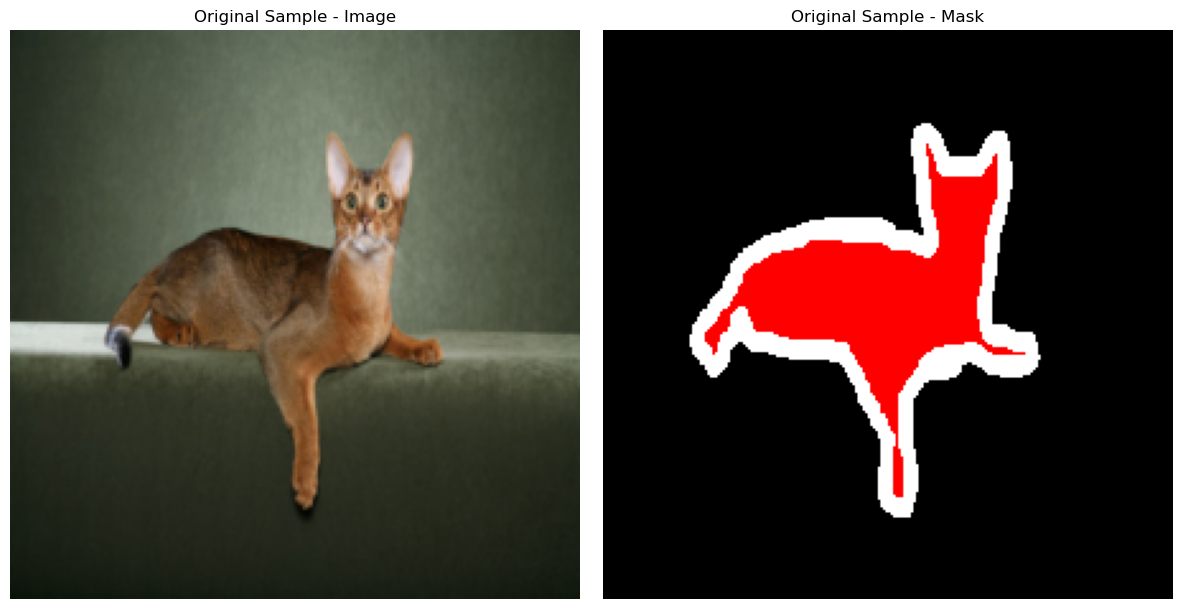

In [15]:
# Load a sample from the original dataset
original_dataset = PetDataset(data_root, 'TrainVal')
if len(original_dataset) > 0:
    sample_idx = 0  # Choose first image for demonstration
    img, mask = original_dataset[sample_idx]
    visualize_sample(img, mask, "Original Sample")
else:
    print("No images found in the original dataset")

## 5. Demonstrate Different Transformations

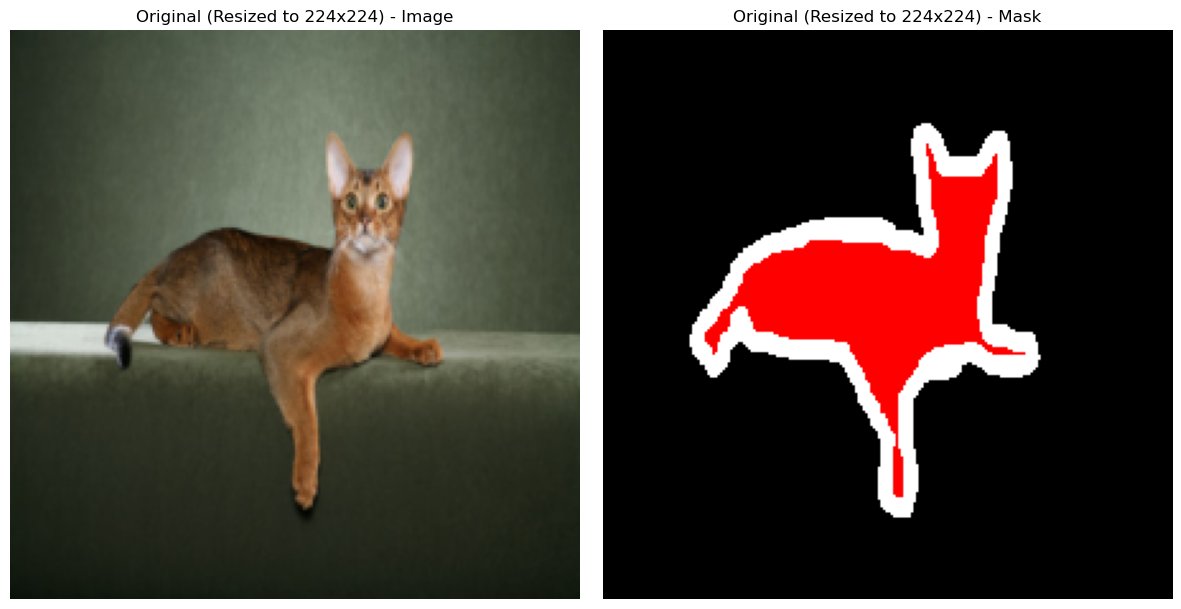

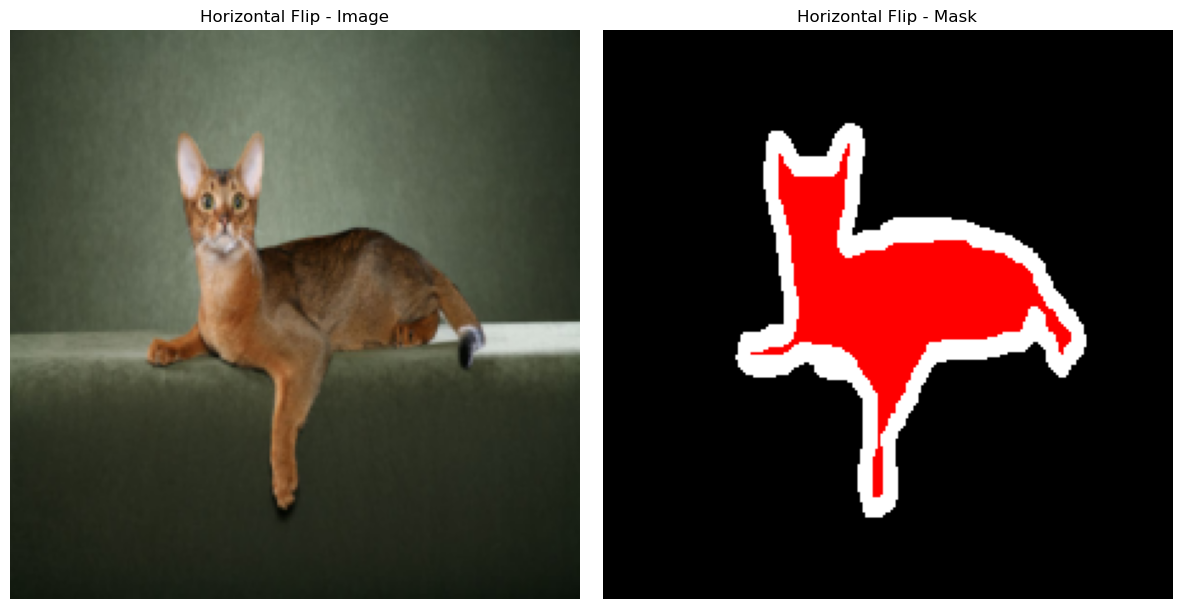

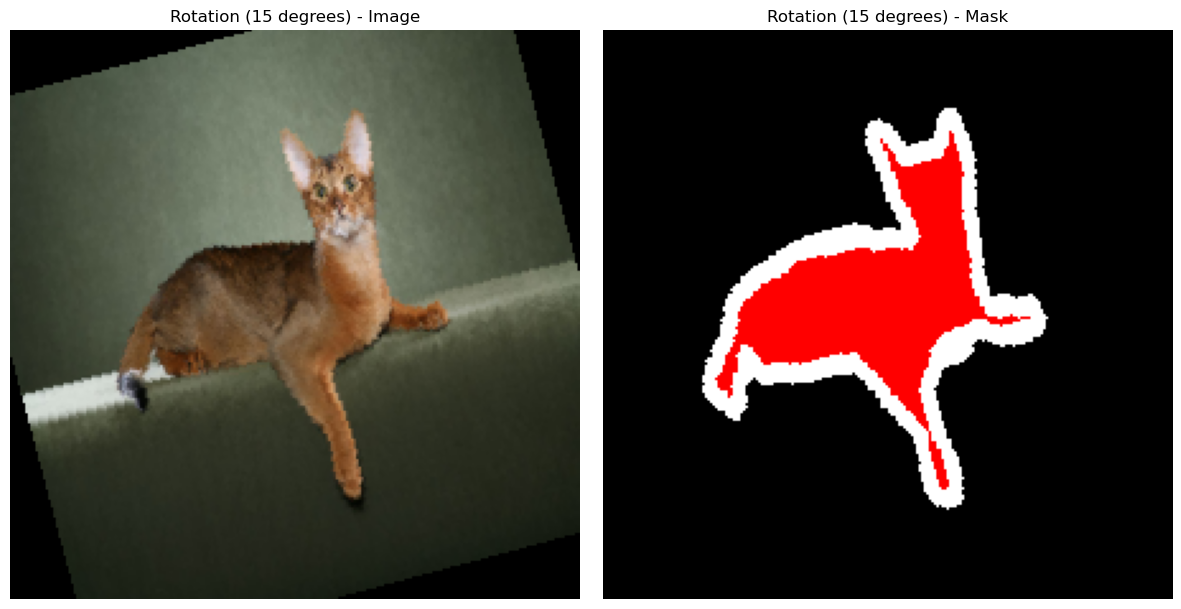

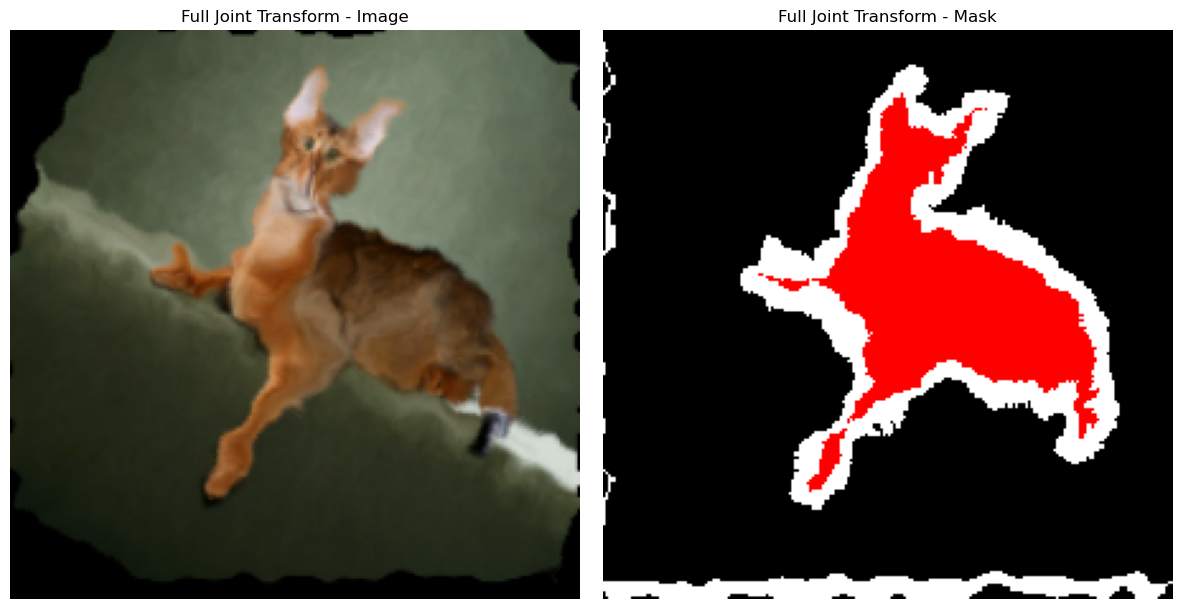


Showing different variations with the full transform:


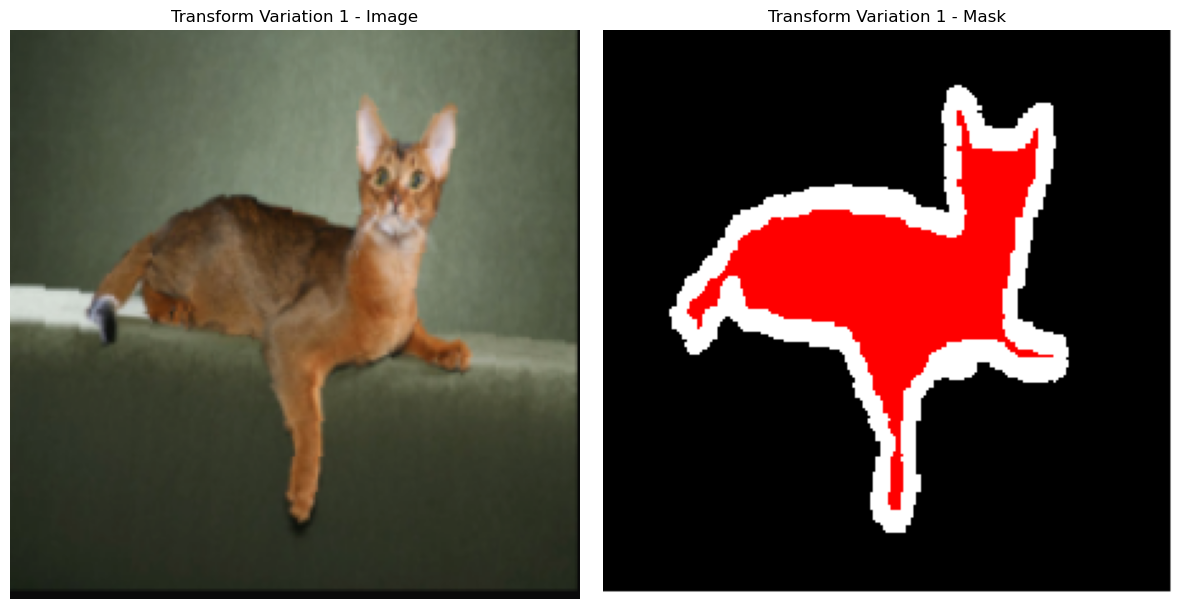

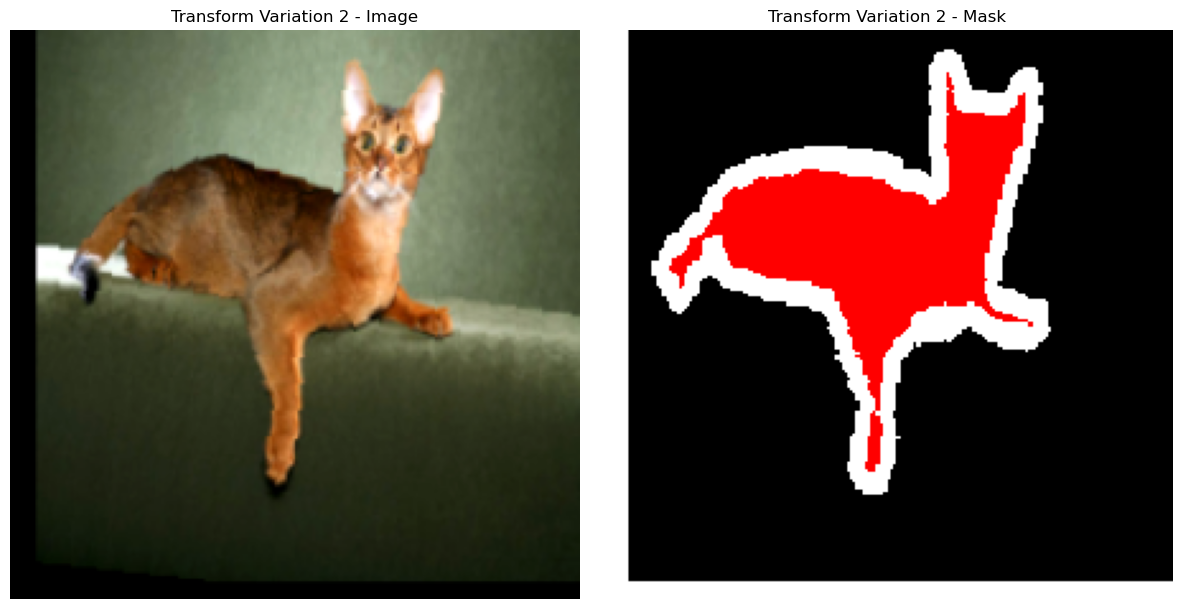

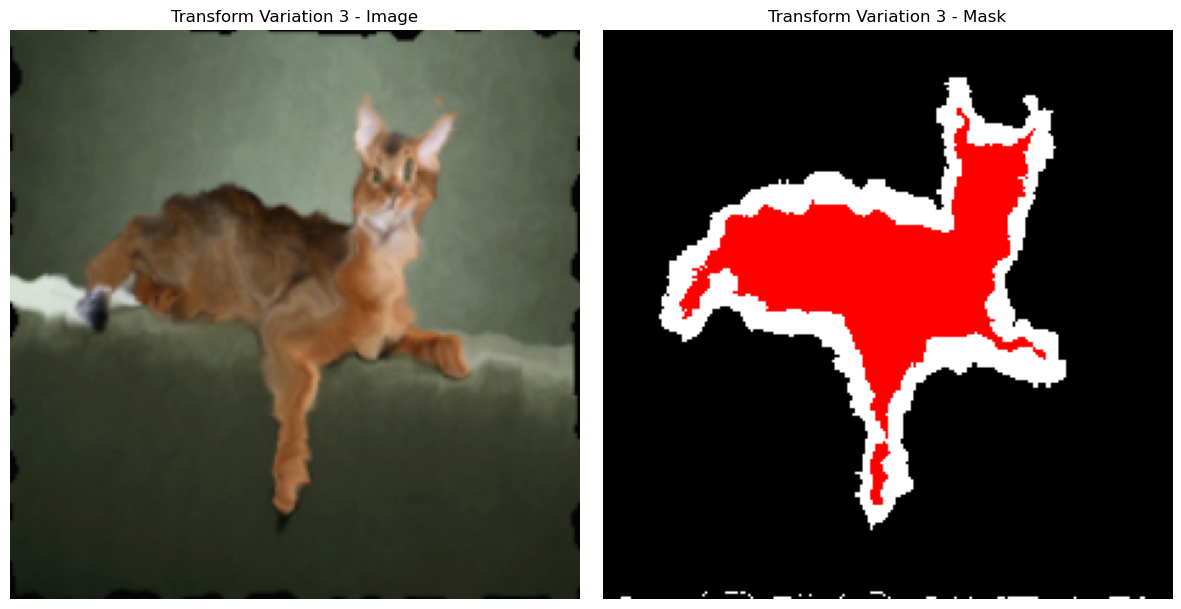

In [16]:
# Load a sample image and mask as PIL images
if len(original_dataset) > 0:
    # Get file paths
    img_name = original_dataset.image_files[sample_idx]
    img_path = os.path.join(train_val_color_dir, img_name)
    mask_name = img_name.replace('.jpg', '.png')
    if not os.path.exists(os.path.join(train_val_label_dir, mask_name)):
        mask_name = img_name.split('.')[0] + '.png'
    mask_path = os.path.join(train_val_label_dir, mask_name)
    
    # Load images
    img_pil = Image.open(img_path).convert('RGB')
    mask_pil = Image.open(mask_path).convert('RGB')
    
    # Process mask
    seg_mask = process_mask_for_visualization(mask_pil)
    seg_mask_pil = Image.fromarray(seg_mask)
    
    # Show original with resize to 224x224
    img_resized = TF.resize(img_pil, (224, 224))
    mask_resized = TF.resize(seg_mask_pil, (224, 224), interpolation=TF.InterpolationMode.NEAREST)
    visualize_sample(img_resized, mask_resized, "Original (Resized to 224x224)")
    
    # Show horizontal flip
    img_flipped = TF.hflip(img_resized)
    mask_flipped = TF.hflip(mask_resized)
    visualize_sample(img_flipped, mask_flipped, "Horizontal Flip")
    
    # Show rotation
    angle = 15
    img_rotated = TF.rotate(img_resized, angle)
    mask_rotated = TF.rotate(mask_resized, angle, interpolation=TF.InterpolationMode.NEAREST)
    visualize_sample(img_rotated, mask_rotated, f"Rotation ({angle} degrees)")
    
    # Show result of full joint transform
    transform = JointTransform(img_size=224, crop_size=196)
    transformed_img, transformed_mask = transform(img_pil, seg_mask_pil)
    visualize_sample(transformed_img, transformed_mask, "Full Joint Transform")
    
    # Show multiple variations of the transform
    print("\nShowing different variations with the full transform:")
    for i in range(3):
        transformed_img, transformed_mask = transform(img_pil, seg_mask_pil)
        visualize_sample(transformed_img, transformed_mask, f"Transform Variation {i+1}")
else:
    print("Cannot demonstrate transformations without sample images")

## 6. Augmented Dataset

The augmented dataset has already been created using the create_augmented_dataset_using_data_preprocessing_script.ipynb notebook. We'll now analyze and visualize the resulting dataset.

In [18]:
# Check if augmented dataset exists
if os.path.exists(augmented_data_root):
    print(f"Using existing augmented dataset at {augmented_data_root}")
    
    # Check the structure to make sure it has train/val/test folders instead of TrainVal
    if os.path.exists(os.path.join(augmented_data_root, 'train')):
        print("Dataset has the correct structure with train/val/test folders")
    else:
        print("Warning: Dataset might have the old structure with TrainVal folder")
        print("   Please run the create_augmented_dataset_using_data_preprocessing_script.ipynb notebook first")
else:
    print(f"Augmented dataset not found at {augmented_data_root}")
    print("Please run the create_augmented_dataset_using_data_preprocessing_script.ipynb notebook first")

Using existing augmented dataset at ../Dataset_augmented/
Dataset has the correct structure with train/val/test folders


## 7. Analyze Augmented Dataset Structure

In [20]:
# Analyze the augmented dataset structure
if os.path.exists(augmented_data_root):
    train_aug_color_dir = os.path.join(augmented_data_root, 'train', 'color')
    train_aug_label_dir = os.path.join(augmented_data_root, 'train', 'label')
    val_aug_color_dir = os.path.join(augmented_data_root, 'val', 'color')
    val_aug_label_dir = os.path.join(augmented_data_root, 'val', 'label')
    test_aug_color_dir = os.path.join(augmented_data_root, 'test', 'color')
    test_aug_label_dir = os.path.join(augmented_data_root, 'test', 'label')
    
    print("Augmented dataset structure:")
    print(f"Train color: {os.path.exists(train_aug_color_dir)}, Files: {len(os.listdir(train_aug_color_dir) if os.path.exists(train_aug_color_dir) else [])}")
    print(f"Train label: {os.path.exists(train_aug_label_dir)}, Files: {len(os.listdir(train_aug_label_dir) if os.path.exists(train_aug_label_dir) else [])}")
    print(f"Val color: {os.path.exists(val_aug_color_dir)}, Files: {len(os.listdir(val_aug_color_dir) if os.path.exists(val_aug_color_dir) else [])}")
    print(f"Val label: {os.path.exists(val_aug_label_dir)}, Files: {len(os.listdir(val_aug_label_dir) if os.path.exists(val_aug_label_dir) else [])}")
    print(f"Test color: {os.path.exists(test_aug_color_dir)}, Files: {len(os.listdir(test_aug_color_dir) if os.path.exists(test_aug_color_dir) else [])}")
    print(f"Test label: {os.path.exists(test_aug_label_dir)}, Files: {len(os.listdir(test_aug_label_dir) if os.path.exists(test_aug_label_dir) else [])}")
    
    # Count original vs augmented files
    if os.path.exists(train_aug_color_dir):
        all_files = os.listdir(train_aug_color_dir)
        original_files = [f for f in all_files if '_aug' not in f]
        augmented_files = [f for f in all_files if '_aug' in f]
        
        print(f"\nIn Train set:")
        print(f"Original files: {len(original_files)}")
        print(f"Augmented files: {len(augmented_files)}")
        print(f"Augmentation ratio: {len(augmented_files)/len(original_files) if len(original_files) > 0 else 0:.1f}x")
        
        if os.path.exists(val_aug_color_dir):
            val_files = os.listdir(val_aug_color_dir)
            print(f"\nIn Val set:")
            print(f"Files: {len(val_files)}")
            print(f"Augmented files: {len([f for f in val_files if '_aug' in f])}")  # Should be 0
else:
    print(f"Augmented dataset not found at {augmented_data_root}")

Augmented dataset structure:
Train color: True, Files: 11796
Train label: True, Files: 11796
Val color: True, Files: 736
Val label: True, Files: 736
Test color: True, Files: 3710
Test label: True, Files: 3710

In Train set:
Original files: 2949
Augmented files: 8847
Augmentation ratio: 3.0x

In Val set:
Files: 736
Augmented files: 0


## 8. Compare Original and Augmented Samples

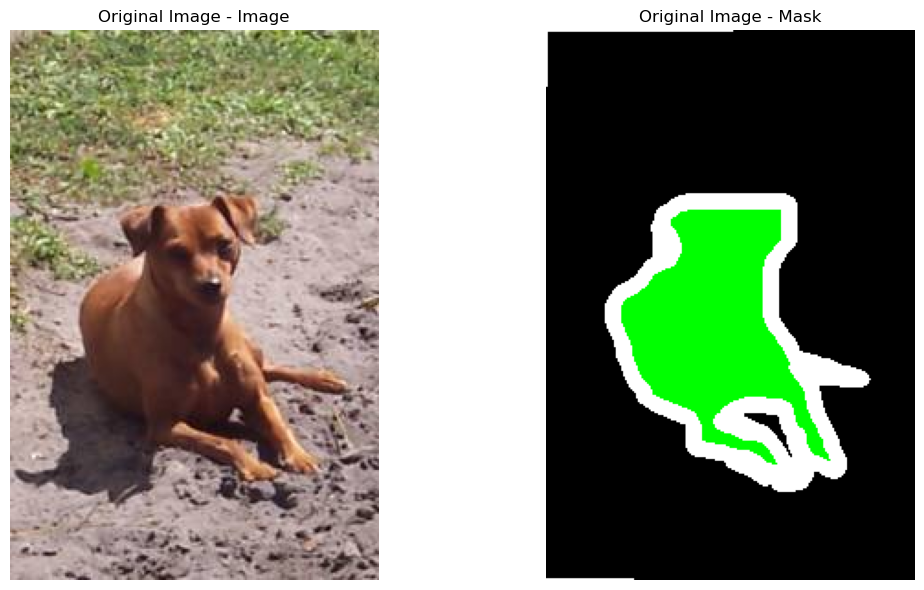

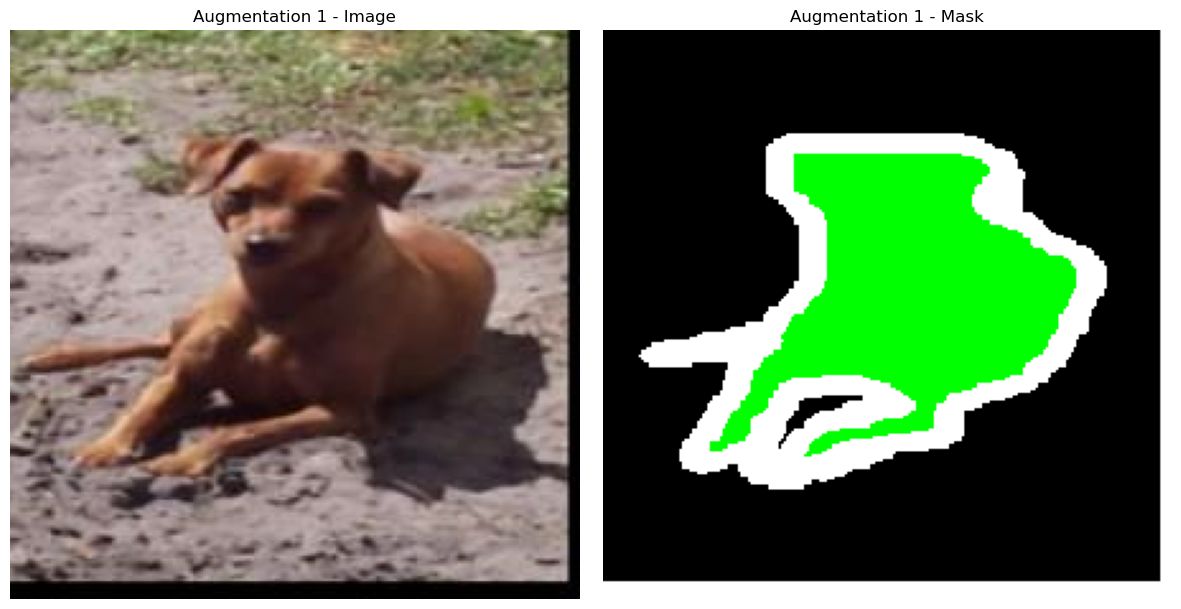

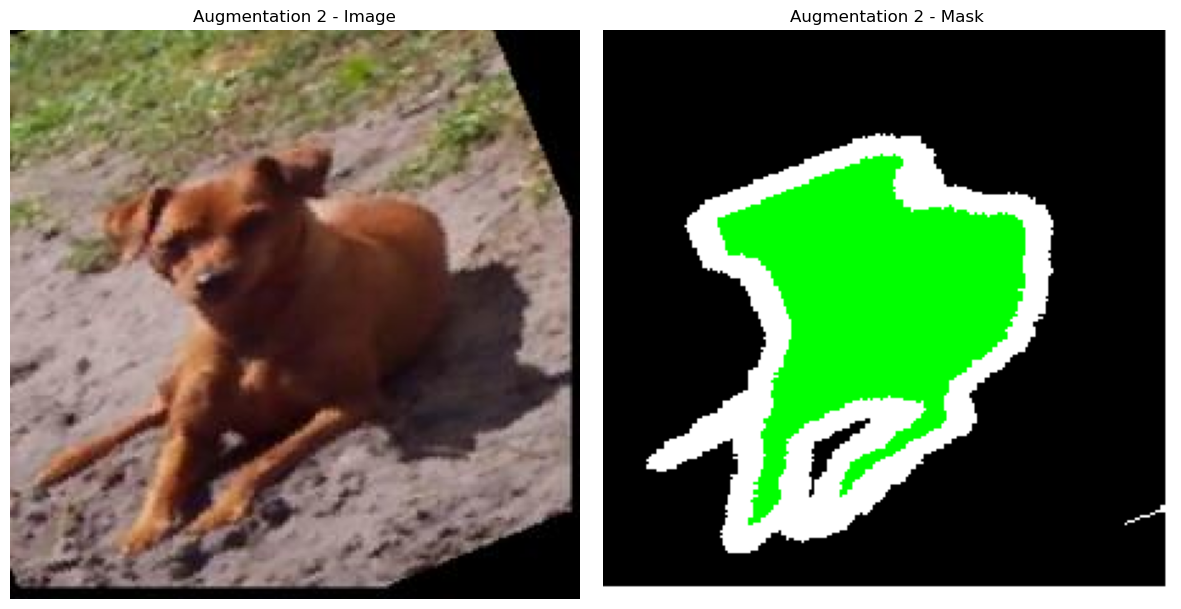

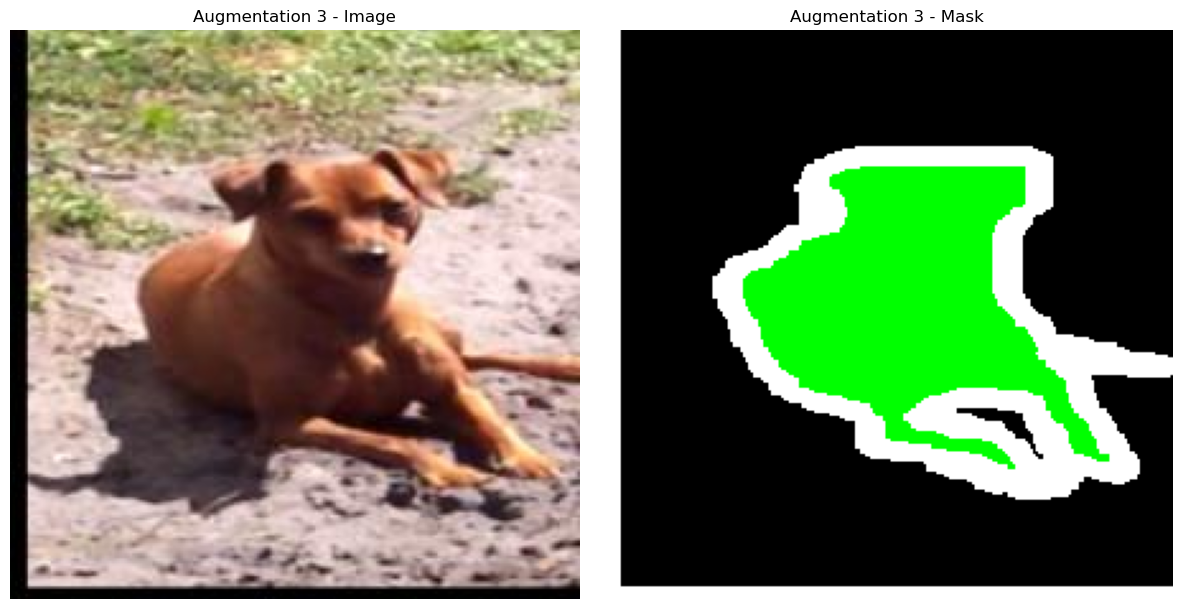

In [22]:
# Find a pair of original and augmented images to compare
train_aug_color_dir = os.path.join(augmented_data_root, 'train', 'color')
train_aug_label_dir = os.path.join(augmented_data_root, 'train', 'label')

if os.path.exists(train_aug_color_dir):
    original_files = [f for f in os.listdir(train_aug_color_dir) if '_aug' not in f]
    if original_files:
        # Take first original file
        original_file = original_files[0]
        base_name = original_file.split('.')[0]
        
        # Find corresponding augmented files
        aug_files = [f for f in os.listdir(train_aug_color_dir) if f.startswith(base_name + '_aug')]
        
        if aug_files:
            # Load original image and mask
            orig_img_path = os.path.join(train_aug_color_dir, original_file)
            orig_mask_name = original_file.replace('.jpg', '.png')
            if not os.path.exists(os.path.join(train_aug_label_dir, orig_mask_name)):
                orig_mask_name = original_file.split('.')[0] + '.png'
            orig_mask_path = os.path.join(train_aug_label_dir, orig_mask_name)
            
            orig_img = Image.open(orig_img_path).convert('RGB')
            orig_mask = Image.open(orig_mask_path).convert('RGB')
            orig_seg_mask = process_mask_for_visualization(orig_mask)
            
            # Show original
            visualize_sample(orig_img, orig_seg_mask, "Original Image")
            
            # Show all augmentations
            for i, aug_file in enumerate(aug_files):
                aug_img_path = os.path.join(train_aug_color_dir, aug_file)
                aug_mask_path = os.path.join(train_aug_label_dir, aug_file.replace('.jpg', '.png'))
                
                aug_img = Image.open(aug_img_path).convert('RGB')
                aug_mask = Image.open(aug_mask_path).convert('RGB')
                aug_seg_mask = process_mask_for_visualization(aug_mask)
                
                visualize_sample(aug_img, aug_seg_mask, f"Augmentation {i+1}")
        else:
            print("No augmented files found for the first original file")
    else:
        print("No original files found in the augmented dataset")
else:
    print(f"Train color directory not found in augmented dataset")

## 9. Create and Test Data Loaders with Train-Val Split (80-20)

In [23]:
# Create data loaders
if os.path.exists(augmented_data_root):
    print("Creating data loaders with 80-20 train-val split...")
    train_loader, val_loader, test_loader = get_data_loaders(augmented_data_root, batch_size=16)
else:
    print(f"Cannot create data loaders because augmented dataset not found at {augmented_data_root}")

Creating data loaders with 80-20 train-val split...
Training set size: 11796
Validation set size: 736
Test set size: 3710


## 10. Verify Data Loaders


Training Batch:
Batch size: 16
Image tensor shape: torch.Size([16, 3, 224, 224])
Mask tensor shape: torch.Size([16, 224, 224])


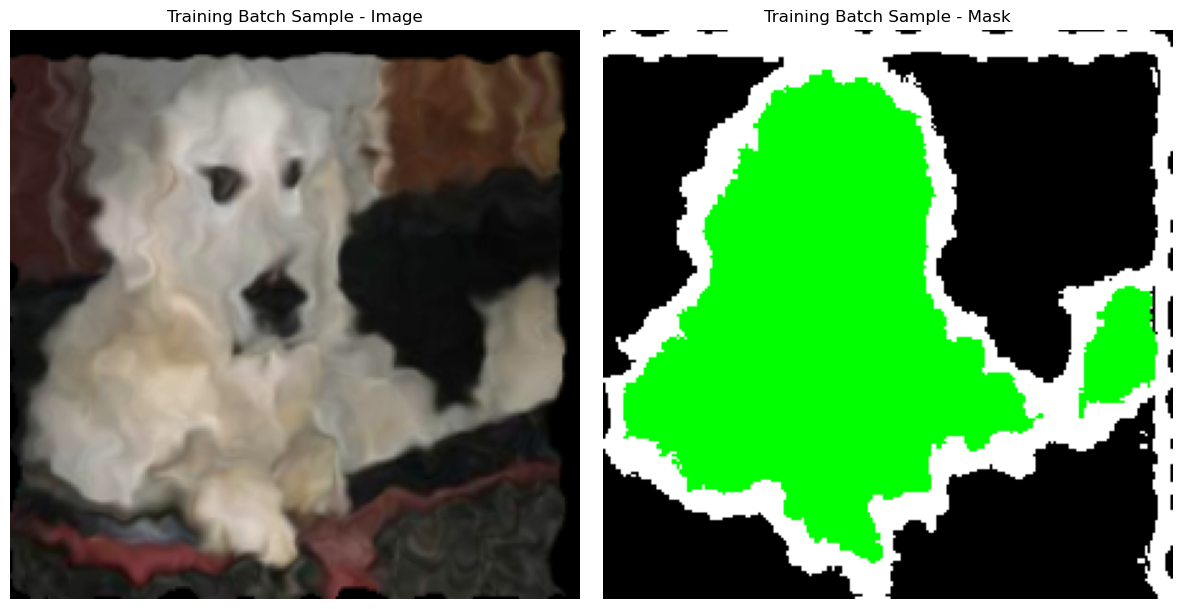


Validation Batch:
Batch size: 16
Image tensor shape: torch.Size([16, 3, 224, 224])
Mask tensor shape: torch.Size([16, 224, 224])


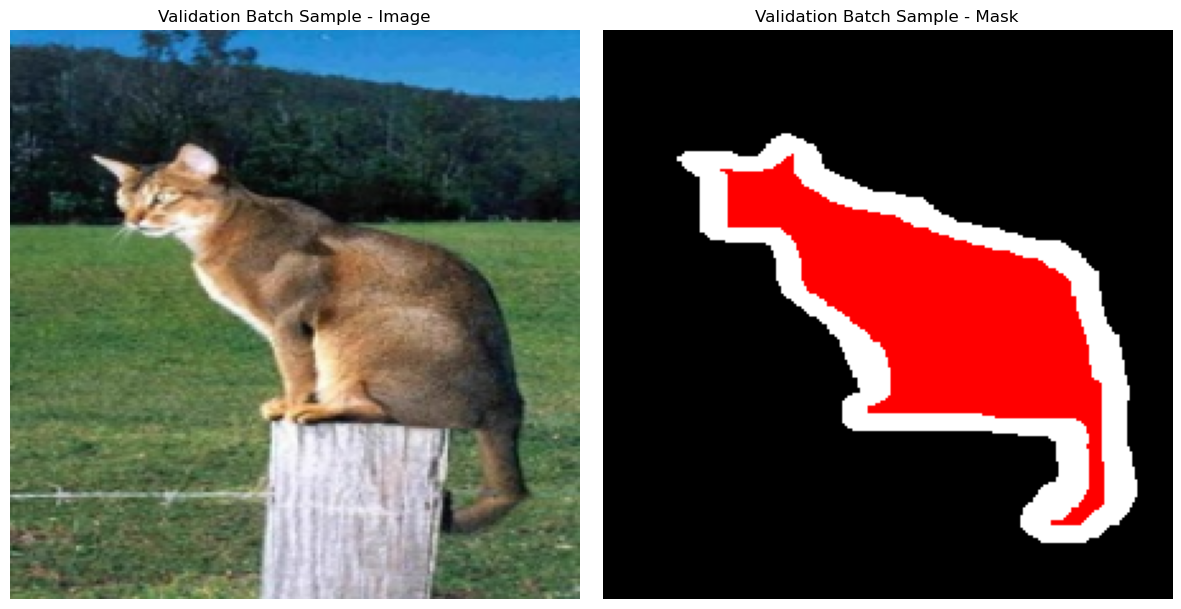


Test Batch:
Batch size: 16
Image tensor shape: torch.Size([16, 3, 224, 224])
Mask tensor shape: torch.Size([16, 224, 224])


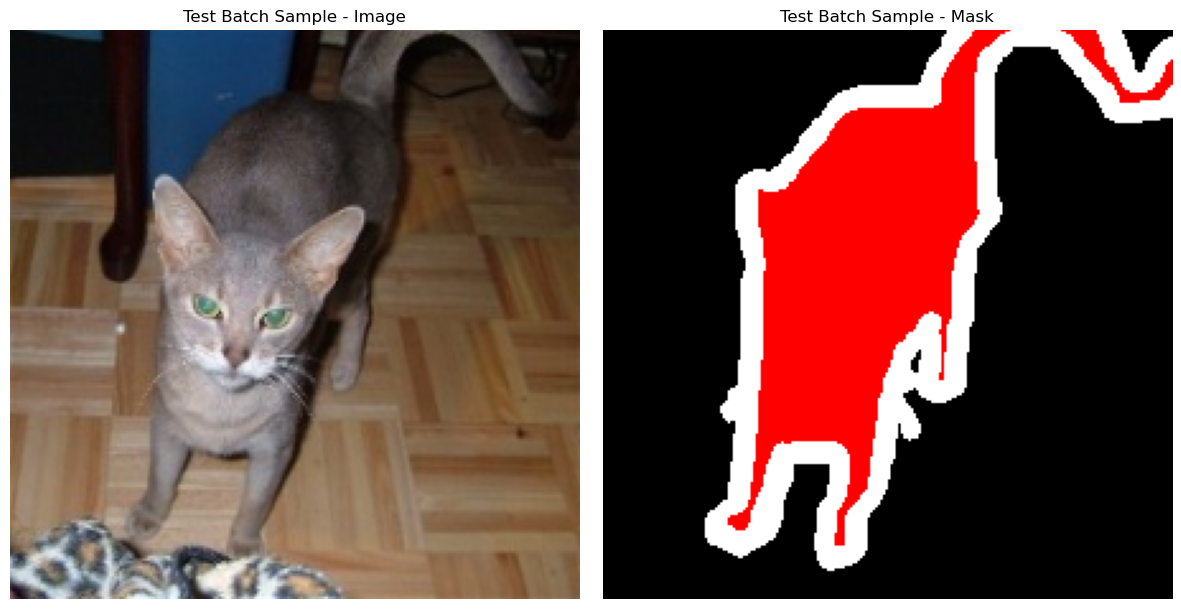


All data loaders are working correctly!


In [24]:
def show_batch(loader, title):
    """Show a sample from a batch"""
    try:
        # Get a batch
        data_iter = iter(loader)
        images, masks = next(data_iter)
        batch_size = images.size(0)
        
        print(f"\n{title}:")
        print(f"Batch size: {batch_size}")
        print(f"Image tensor shape: {images.shape}")
        print(f"Mask tensor shape: {masks.shape}")
        
        # Show a random sample from the batch
        idx = random.randint(0, batch_size-1)
        sample_img = images[idx]
        sample_mask = masks[idx]
        
        visualize_sample(sample_img, sample_mask, f"{title} Sample")
        return True
    except Exception as e:
        print(f"Error showing batch from {title}: {e}")
        return False

# Show a batch from each loader
if 'train_loader' in locals():
    # Check train loader
    train_ok = show_batch(train_loader, "Training Batch")
    
    # Check val loader
    val_ok = show_batch(val_loader, "Validation Batch")
    
    # Check test loader
    test_ok = show_batch(test_loader, "Test Batch")
    
    if train_ok and val_ok and test_ok:
        print("\nAll data loaders are working correctly!")
    else:
        print("\nSome data loaders had errors.")
else:
    print("Data loaders not created yet")

#### Summary:
1. We've modified the data preprocessing code to:
   - Use 224x224 as the final image size for models
   - Create a proper augmented dataset with both original and transformed images
   - Apply the joint transformations properly
   - Create data loaders with an 80-20 train-validation split
2. We've created an augmented dataset at '../Dataset_augmented/' that:
   - Contains all original images
   - Contains 3 augmented versions of each original TrainVal image
   - Maintains the same directory structure as the original dataset
3. We've verified that:
   - The transformations work as expected
   - The data loaders can properly load the data
   - The train-val split is correct
   - All images are properly resized to 224x224